In [1]:
%matplotlib inline
!pip install deeptrack

<!--<badge>--><a href="https://colab.research.google.com/github/softmatterlab/DeepTrack-2.0/blob/develop/examples/paper-examples/4-multi-molecule-tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

# Example 4. Multi-particle tracking

## 1. Setup

Imports the objects needed for this example.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import deeptrack as dt

from deeptrack.extras import datasets
datasets.load('QuantumDots')

IMAGE_SIZE = 128

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\backend\_config.py:11: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\backend\_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")


Dataset already downloaded.


## 2. Defining the dataset

### 2.1 Defining the training set

The training set consists of simulated 128 by 128 pixel images, containing multiple particles each. The particles are simulated as point scatterers. Their position in the camera plane is constrained to be within the image, and is sampled with a normal distribution with standard deviation of 5 pixel units in along the axis normal to the camera plane. 

In [3]:
particle = dt.PointParticle(
    position=lambda: np.random.rand(2) * IMAGE_SIZE,
    z=lambda: np.random.randn() * 5,
    intensity=lambda: 1 + np.random.rand() * 9,
    position_unit="pixel",
)

number_of_particles = lambda: np.random.randint(10, 20)

particles = particle ^ number_of_particles

The particles are imaged using a fluorescence microscope with NA between 0.6 and 0.8, illuminating laser wavelength of 500 nm, and a magnification of 10.

In [4]:
optics = dt.Fluorescence(
    NA=lambda: 0.6 + np.random.rand() * 0.2,
    wavelength=500e-9,
    resolution=1e-6,
    magnification=10,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
)

The noise is simulated as poisson noise with a signal to noise ratio between 4 and 7. The image is finally normalized by rescaling it to be contained between two random numbers within (0, 1).

In [5]:

normalization = dt.NormalizeMinMax(
    min=lambda: np.random.rand() * 0.4,
    max=lambda min: min + 0.1 + np.random.rand() * 0.5,
)

noise = dt.Poisson(
    snr=lambda: 4 + np.random.rand() * 3,
    background=normalization.min
)


We now define how these objects combine

In [6]:
imaged_particle = optics(particles)

dataset = imaged_particle >> normalization >> noise

### 2.2 Defining the training label

Each particle is represented by a disk with a radius of 3 pixels.

In [7]:
CIRCLE_RADIUS = 3

X, Y = np.mgrid[:2*CIRCLE_RADIUS, :2*CIRCLE_RADIUS]

circle = (X - CIRCLE_RADIUS + 0.5)**2 + (Y - CIRCLE_RADIUS + 0.5)**2 < CIRCLE_RADIUS**2
circle = np.expand_dims(circle, axis=-1)

get_masks = dt.SampleToMasks(
    lambda: lambda image: circle,
    output_region=optics.output_region,
    merge_method="or"
)

def get_label(image_of_particles):
    return get_masks.update().resolve(image_of_particles)

### 2.3 Visualizing the dataset

We resolve and show 16 images.

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.20368483555245 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:276: RuntimeWarning: invalid value encountered in sqrt
  * np.sqrt(1 - (NA / refractive_index_medium) ** 2 * RHO),


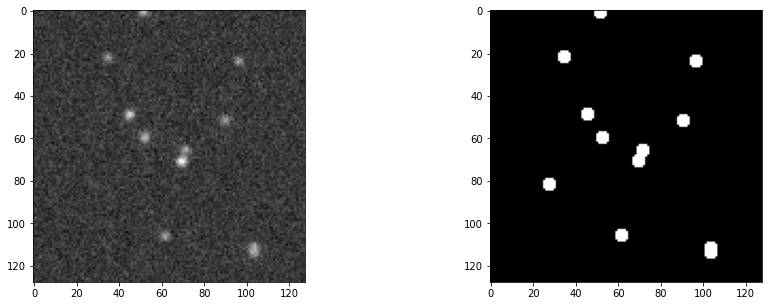

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.999175150221156 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


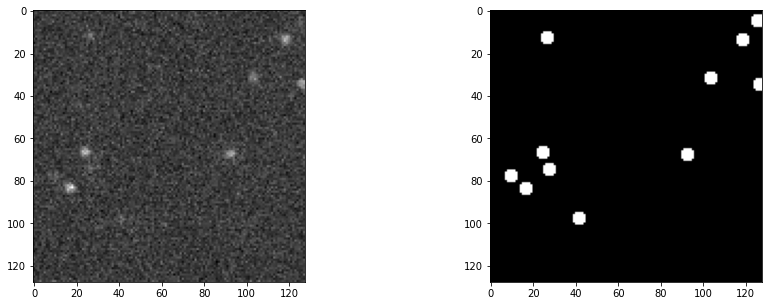

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.19157586234558 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


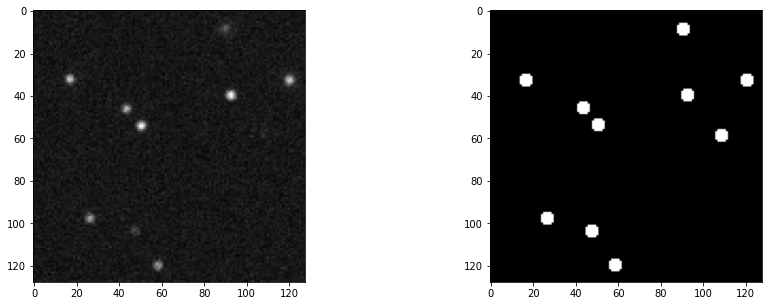

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.901291583246511 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


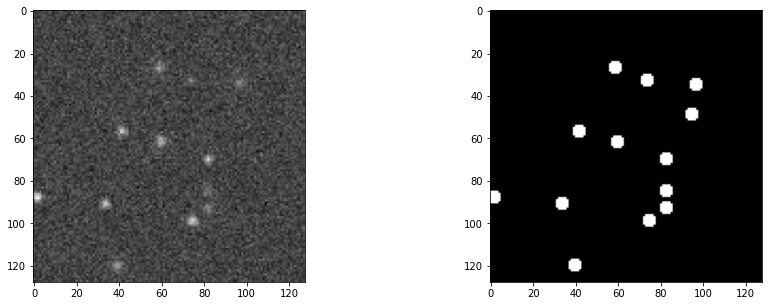

In [8]:
NUMBER_OF_IMAGES = 4

for _ in range(NUMBER_OF_IMAGES):
    plt.figure(figsize=(15, 5))
    dataset.update()
    image_of_particle = dataset.resolve(skip_augmentations=True)
    particle_label = get_label(image_of_particle)
    plt.subplot(1, 2, 1)
    plt.imshow(image_of_particle[..., 0], cmap="gray")
    plt.subplot(1, 2, 2)
    plt.imshow(particle_label[..., 0] * 1.0, cmap="gray")
    plt.show()
    

## 3. Defining the network

The network used is a U-Net, with a the pixel error as loss.

In [9]:
import tensorflow.keras.backend as K
import tensorflow.keras.optimizers as optimizers

loss = dt.losses.flatten(
    dt.losses.weighted_crossentropy((10, 1))
)
metric = dt.losses.flatten(
    dt.losses.weighted_crossentropy((1, 1))
)
model = dt.models.UNet(
    (None, None, 1), 
    conv_layers_dimensions=[16, 32, 64],
    base_conv_layers_dimensions=[128, 128], 
    loss=loss,
    metrics=[metric],
    output_activation="sigmoid"
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   160         ['input_1[0][0]']                
                                16)                                                               
                                                                                                  
 activation (Activation)        (None, None, None,   0           ['conv2d[0][0]']                 
                                16)                                                           

## 4. Training the network

The network is trained similarly to example 2.

In [10]:
TRAIN_MODEL = True

validation_set_size = 100

validation_set = [dataset.update().resolve() for _ in range(validation_set_size)]
validation_labels = [get_label(image) for image in validation_set]

if TRAIN_MODEL:
    generator = dt.generators.ContinuousGenerator(
        dataset & (dataset >> get_label),
        batch_size=16,
        min_data_size=1e3,
        max_data_size=1e4,
    )

    with generator:

        # Train 5 epochs with weighted loss
        h = model.fit(generator,
                      epochs=10,
                         validation_data=(
                              np.array(validation_set),
                              np.array(validation_labels)
                          ))

        model.compile(loss=metric, optimizer="adam")

        # Train 30 epochs with unweighted loss
        h2 = model.fit(generator,
                      epochs=60,
                      validation_data=(
                          np.array(validation_set),
                          np.array(validation_labels)
                      ))
        
else:
    model_path = datasets.load_model("QuantumDots")
    model.load_weights(model_path)

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.253959005002361 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.734783463053265 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.731273448157776 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.477586392197614 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.890960278289551 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.701938534349093 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.277828755485421 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.02052598790636 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.712635532253994 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\de

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.513808131477187 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.399072380018689 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.025199578679963 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.21637031381851 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.86484311910791 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.508880681127891 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\dee

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.506005478517253 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.693295729884817 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.086355262404755 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.75659573901833 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.94515159875257 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.985628635237864 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\dee

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.40623650994123 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.64814702757904 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.667798463262011 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\dee

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.956955929798955 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.103882344226333 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.118211936046697 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.612419609302954 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.854200048424211 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.022501486206881 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.726033474992025 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.766433438931653 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.89198331333959 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\de

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.99988893963048 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.487833440888402 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.466082667312685 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\de

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.80245633908039 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.248827128177663 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.01402584762375 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\dee

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.315506395567132 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.360079170539276 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.543839816792534 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.597525293965289 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.327605742860804 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.01336977931544 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\de

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.956054440210558 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.864054805778796 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.722488835310793 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.254432390735648 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.456473654563634 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.376731226612094 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.466300267090983 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.23482293938892 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.220122767424975 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\de

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.741614348860104 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.415319087292797 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.027431097990299 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.089937600675423 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.377438351843221 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.225139270849407 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.621166447762533 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.251805418715927 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.723153620943378 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.087664517517691 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.829721521702897 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.380786968029836 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.873515332063356 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.771605721057382 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.474814093944046 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.288469529331119 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.772906876141416 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.92508658988142 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\de

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.849435037604152 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.543247914571246 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.107727283051867 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.001509733697803 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.376150150735066 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.04983569484728 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\de

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.842088815531131 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.733453110048767 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.223062992815812 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.186401842678155 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.474829112492763 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.096352165747849 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.174221151426941 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.747071610226046 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.555586473838643 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.73364000055167 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.222507330745465 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.757976032738114 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\de

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.187757253375091 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.384433673031744 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.323748001453918 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.147129552339411 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.020606681216524 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.944279691281462 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.883806660588512 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.477412165530877 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.162646285529789 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.024787585789134 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.715151118479938 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.270992492994425 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.65423715184265 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.185484800624792 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.893699946847278 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\de

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.99117516011123 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.12902426764026 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.38420191919992 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deep

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.487766267179452 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.879377232769718 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.308455003391733 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.508219451693448 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.054578389005101 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.441774505329645 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.889982401701797 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.79076159767987 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.354494078663791 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\de

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.99754082946141 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.902431480010012 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.72104864491189 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\dee

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.931400927534852 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.532699003605837 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.047892926380287 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.048579483362248 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.852015467462122 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.804959637651812 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.345011400713366 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.440145769384873 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.61574618617285 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\de

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.99196764563655 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.970705052758271 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.709198992881236 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\de

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.86771665157438 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.863532636475806 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.076239753796438 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\de

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.88595044927412 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.22881099188715 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.904423198473445 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\dee

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.993051141773153 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.301959876349448 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.05624080229511 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\de

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.345226541274304 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.405501556656102 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.32704136570617 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\de

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.906920006993623 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.575501431289695 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.784670786161708 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.263188491384485 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.874607916331875 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.327674332543118 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.556332941344422 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.221788470532157 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.627488555355308 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.992130320807938 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.071957399883047 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.750982151312845 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.097121031167134 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.897510168541015 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.02866685296312 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\de

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.880618602079265 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.953130945912388 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.190631250821946 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.186549408181659 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.336557472433299 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.50048833731016 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\de

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.69215141877689 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.898169229159695 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.937886571054584 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\de

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.758342300118455 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.800580970915622 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.272254853867274 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.4615552587368 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.299252824401243 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.799239707031074 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\dee

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.124030418549765 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.694463044332167 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.301109932850153 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.867946338492743 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.404243310092134 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.020753250413122 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.021950950875414 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.572938087494231 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.033078321270166 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.053370979764267 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.696449443374398 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.537820738531769 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.429666027577762 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.361192927584433 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.553102454931008 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.456247159332083 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.47683963070764 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.695184008549244 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\de

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.809702990801311 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.776612650505811 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.21348643145598 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\de

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.987250616032417 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.247183701078278 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.038891545802908 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.989159329409643 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.955499226979715 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.779751936387328 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.646451020481537 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.956839635229633 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.074688175147374 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.926594905238938 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.127504629297466 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.012689950079379 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.349954209473536 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.16176145866222 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.440805678271097 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.855537477242395 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.192771429542987 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.688706152383947 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.795665781466322 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.451968847004053 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.28931971260134 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\de

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.00800411449742 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.371958958734023 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.199878867729987 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\de

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.916929280659202 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.59025109774706 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.046189884433197 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\de

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.256141946887215 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.10209706434588 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.028901462453675 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\de

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.672669437720451 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.849892849298417 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.639031054212928 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.353791685892366 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.785020835611222 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.870320603339119 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.85806345531285 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.188472637366099 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.077864093245724 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\de

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.531523489647137 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.379556959450742 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.964199330460598 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.927320824993298 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.715584959076834 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.320086951163768 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.12704300647039 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.246827221397929 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.54036768571151 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\dee

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.191473169524421 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.477872448254384 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.419417671682496 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.043386579061886 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.715064228612444 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.427962014893913 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.415386406170178 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.056425721525338 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.764314345487254 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.167339446635376 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.606314193187593 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.263980841882095 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.437507943099043 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.949409733034559 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.035895230534617 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.873804179424516 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.255947161893186 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.122025840781092 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.331799150045052 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.846648842781073 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.749036680078676 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.516828861948255 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.419154320123887 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.597170349913949 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.410021396707382 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.792296810122792 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.374753829404858 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.940133102420603 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.249640927014001 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.366746878721846 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.32404780918583 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.404874132717211 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.458661737757335 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\de

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.714328970149538 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.910934032749141 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.401216036875718 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.494467640906176 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.352031046821356 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.30818903184422 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\de

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.940317896189672 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.261055885932366 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.564668268226061 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.520730187692585 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.786833942707423 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.217222265784597 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.331342329395133 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.084675496019397 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.79815461072996 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\de

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.812433901907074 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.759825305977092 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.138581767226455 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.714643514896782 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.632872803116669 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.441898174462981 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.6096540188107 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.373098189385633 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.982175655975803 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\dee

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.077285864713078 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.420524216144795 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.87087041212998 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\de

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.307854848711216 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.787051556118488 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.021587778357947 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.455898686606488 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.073144207182656 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.296449176919552 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.453388585936832 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.682930534120633 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.079741528192065 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.431391888395753 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.53914137163052 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.927579298299735 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\de

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.967351914423206 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.395348913800378 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.845093898451955 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.961292374987066 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.28042417406442 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.810304014430887 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\de

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.818131267785077 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.293351239877314 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.335728623379225 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.106752820733108 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.606682173385263 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.715263123402458 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.520564707524185 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.007305036316074 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.484357389003678 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.257479961757955 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.946680869436952 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.777762083277132 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.658423587305206 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.489269010973596 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.933035339085059 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.226296685812402 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.024242161179657 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.793039858979176 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.476289577676635 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.923802019734946 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.24097073227604 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\de

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.952278243273676 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.049497667481466 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.156119025120738 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.171738842925318 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.42955484415334 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.099292158570732 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\de

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.502325432160898 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.753603885538338 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.53326944355496 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\de

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.651873496429605 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.977726704214458 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.11257363466261 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\de

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.271533575292151 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.351637507147577 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.22674428088213 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\de

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.332000646702516 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.640801399790663 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.337726763082905 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.445721051569302 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.472897898562099 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.465376846919199 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.081520260935681 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.224559403039857 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.836841959364845 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.670093140751018 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.903294590169061 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.12576342755786 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\de

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.023079014779857 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.96395848883946 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.03026357984292 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\dee

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.988851572478787 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.31303349886727 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.673876493577762 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\de

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.445573237340238 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.910201478682682 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.143541446221324 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.099386610363618 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.641953594824296 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.541818778348944 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.184135064831182 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.034922326905559 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.197974562893325 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.262947605388245 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.400843218661182 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.713882100954727 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.583358322258746 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.390303566200933 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.599179841939847 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.830955538831033 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.662950719071926 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.22094490524966 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\de

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.529484880675424 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.454914905099965 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.174181027241929 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.954074154091215 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.73242810576042 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.559476255515282 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\de

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.439798606008537 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.5779974237618 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.806295104978123 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\dee

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.926693823142106 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.919026130890852 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.290847363600484 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.224691155236865 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.241279996175994 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.119767439479503 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.388282053000278 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.729393262449904 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.4054736522231 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\dee

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.234302324164135 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.784475673494576 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.471335543327026 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.98176874876778 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.759417005369976 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.679170649627675 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\de

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.291332577029124 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.115163941838977 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.603500944470044 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.99605213488065 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.313965253866451 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.020373167688346 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\de

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.356222437890194 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.991994321368853 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.46367158430774 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\de

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.467803633701498 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.049393917966 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.593530780032129 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.945764150661521 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.574322490971259 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.844525506255053 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.156317149462694 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.409109027179532 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.171874471779608 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.812863749630056 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.485269727168822 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.200544633139407 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.105981059523772 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.046865970985156 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.692539122569798 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.194010189818385 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.877549548259648 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.525465924035561 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.378483558205025 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.374143887247515 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.86525329882511 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\de

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.57317856559477 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.733400830388828 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.714153461272362 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\de

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.524176861864404 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.462455862187708 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.770221716941162 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.926501870707659 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.720141466098845 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.39716211201841 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\de

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.27581388920694 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.437800847178503 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.181364110599127 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\de

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.932155244075409 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.024738255172362 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.95530298491218 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\de

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.456443166765466 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.326165035740509 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.027122966855751 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.595497638291187 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.660315188622075 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.076262451314385 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.037986328992863 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.013510435567783 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.357944790121186 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

Generating 1003 / 1000.0 samples before starting training
Epoch 1/10


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.963002971190651 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.788975274544393 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.364220909182448 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

11/62 [====>.........................] - ETA: 0s - loss: 0.0703 - nd_unet_crossentropy: 0.2576

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.261191144386835 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.776285750344549 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.55088693867637 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


37/62 [================>.............] - ETA: 0s - loss: 0.0632 - nd_unet_crossentropy: 0.1813

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.762339952541344 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.571043818913683 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.586355569561492 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


61/62 [============================>.] - ETA: 0s - loss: 0.0558 - nd_unet_crossentropy: 0.1473

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.522112053175361 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.692703965118355 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.593954633194155 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\d

62/62 [==============================] - 8s 21ms/step - loss: 0.0554 - nd_unet_crossentropy: 0.1457 - val_loss: 0.0369 - val_nd_unet_crossentropy: 0.0375
Epoch 2/10
18/62 [=======>......................] - ETA: 0s - loss: 0.0270 - nd_unet_crossentropy: 0.0578

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.593624437883927 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.15971339521704 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(


33/62 [==============>...............] - ETA: 0s - loss: 0.0231 - nd_unet_crossentropy: 0.0539

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.485391060678321 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.586932428576766 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.88429576240988 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


58/62 [===========================>..] - ETA: 0s - loss: 0.0202 - nd_unet_crossentropy: 0.0483

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.687454332741021 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.830274103388266 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0197 - nd_unet_crossentropy: 0.0472 - val_loss: 0.0128 - val_nd_unet_crossentropy: 0.0383
Epoch 3/10
 7/62 [==>...........................] - ETA: 0s - loss: 0.0141 - nd_unet_crossentropy: 0.0335

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.912826455098994 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.27288224858442 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(


25/62 [===========>..................] - ETA: 0s - loss: 0.0146 - nd_unet_crossentropy: 0.0360

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.650257842312556 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.231560852705815 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.662510012693625 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


51/62 [=======================>......] - ETA: 0s - loss: 0.0133 - nd_unet_crossentropy: 0.0336

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.399990065718008 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.77868926883232 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.712184054413495 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0129 - nd_unet_crossentropy: 0.0327 - val_loss: 0.0106 - val_nd_unet_crossentropy: 0.0356
Epoch 4/10
 6/62 [=>............................] - ETA: 0s - loss: 0.0107 - nd_unet_crossentropy: 0.0289

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.66076749104932 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.231474022103583 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.143316921246942 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(


28/62 [============>.................] - ETA: 0s - loss: 0.0109 - nd_unet_crossentropy: 0.0277

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.683133637199381 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.381960301175603 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


51/62 [=======================>......] - ETA: 0s - loss: 0.0104 - nd_unet_crossentropy: 0.0266

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.289188126675755 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.455070122136853 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.354246208035809 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0102 - nd_unet_crossentropy: 0.0261 - val_loss: 0.0097 - val_nd_unet_crossentropy: 0.0323
Epoch 5/10
 7/62 [==>...........................] - ETA: 0s - loss: 0.0106 - nd_unet_crossentropy: 0.0282

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.53892164164666 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.746874014842058 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.98717079462898 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


31/62 [==============>...............] - ETA: 0s - loss: 0.0098 - nd_unet_crossentropy: 0.0254

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.84295637661421 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.572563129255107 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.196415670867465 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(


51/62 [=======================>......] - ETA: 0s - loss: 0.0099 - nd_unet_crossentropy: 0.0257

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.36322807415414 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.126697302977918 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0099 - nd_unet_crossentropy: 0.0256 - val_loss: 0.0101 - val_nd_unet_crossentropy: 0.0353
Epoch 6/10
 5/62 [=>............................] - ETA: 0s - loss: 0.0102 - nd_unet_crossentropy: 0.0244

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.269777363857795 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.430530058533565 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.002961895828893 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(


25/62 [===========>..................] - ETA: 0s - loss: 0.0089 - nd_unet_crossentropy: 0.0228

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.710750882155999 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.19301731512573 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


44/62 [====================>.........] - ETA: 0s - loss: 0.0087 - nd_unet_crossentropy: 0.0225

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.535488614793394 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.765631326339753 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


59/62 [===========================>..] - ETA: 0s - loss: 0.0088 - nd_unet_crossentropy: 0.0227

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.779954707252097 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.142949302143887 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0089 - nd_unet_crossentropy: 0.0227 - val_loss: 0.0087 - val_nd_unet_crossentropy: 0.0185
Epoch 7/10
11/62 [====>.........................] - ETA: 0s - loss: 0.0080 - nd_unet_crossentropy: 0.0221

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.66214602918198 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.872077577359933 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(


27/62 [============>.................] - ETA: 0s - loss: 0.0082 - nd_unet_crossentropy: 0.0217

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.075358658818981 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.088182112612682 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


46/62 [=====================>........] - ETA: 0s - loss: 0.0085 - nd_unet_crossentropy: 0.0220

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.247541177739802 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.199723221018477 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0085 - nd_unet_crossentropy: 0.0219 - val_loss: 0.0082 - val_nd_unet_crossentropy: 0.0231


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.283392785401103 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.865195295751452 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


Epoch 8/10
12/62 [====>.........................] - ETA: 0s - loss: 0.0079 - nd_unet_crossentropy: 0.0217

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.295181155489633 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.43508454210347 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.092795035738916 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(


37/62 [================>.............] - ETA: 0s - loss: 0.0086 - nd_unet_crossentropy: 0.0222

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.271212863870131 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.50061111588664 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.968095220560675 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


60/62 [============================>.] - ETA: 0s - loss: 0.0086 - nd_unet_crossentropy: 0.0221

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.458378451909818 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.195144425320091 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0085 - nd_unet_crossentropy: 0.0223 - val_loss: 0.0086 - val_nd_unet_crossentropy: 0.0257
Epoch 9/10
10/62 [===>..........................] - ETA: 0s - loss: 0.0085 - nd_unet_crossentropy: 0.0210

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.532885548274503 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.784092155204338 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.82667821736054 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


36/62 [================>.............] - ETA: 0s - loss: 0.0081 - nd_unet_crossentropy: 0.0209

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.765659271306028 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.01522280775324 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(


52/62 [========================>.....] - ETA: 0s - loss: 0.0082 - nd_unet_crossentropy: 0.0214

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.468163414057052 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.650652597507932 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0083 - nd_unet_crossentropy: 0.0215 - val_loss: 0.0079 - val_nd_unet_crossentropy: 0.0179
Epoch 10/10
 6/62 [=>............................] - ETA: 0s - loss: 0.0078 - nd_unet_crossentropy: 0.0210

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.732542264906101 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.185048450948454 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.260972709139097 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


27/62 [============>.................] - ETA: 0s - loss: 0.0078 - nd_unet_crossentropy: 0.0205

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.973797148766067 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.796465068270512 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.460631112268842 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(


54/62 [=========================>....] - ETA: 0s - loss: 0.0077 - nd_unet_crossentropy: 0.0204

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.060773939453803 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.096677814333885 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.650931385513744 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 11ms/step - loss: 0.0077 - nd_unet_crossentropy: 0.0202 - val_loss: 0.0079 - val_nd_unet_crossentropy: 0.0189
Epoch 1/60


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.63856299203052 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.606868814490168 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.400293084813246 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\de

 6/62 [=>............................] - ETA: 0s - loss: 0.0242 

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.79298483509271 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.42946766756899 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(


21/62 [=========>....................] - ETA: 0s - loss: 0.0178

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.74765876625218 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.008385313325807 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.160731357819897 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


41/62 [==================>...........] - ETA: 0s - loss: 0.0145

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.342097930202083 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.785976541840176 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.614416032531107 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


61/62 [============================>.] - ETA: 0s - loss: 0.0131

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.817339584820852 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.393886733606653 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.759479468543267 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


62/62 [==============================] - 2s 15ms/step - loss: 0.0131 - val_loss: 0.0100
Epoch 2/60
10/62 [===>..........................] - ETA: 0s - loss: 0.0099

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.59529863784659 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.646351404307161 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.354381494361773 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(


35/62 [===============>..............] - ETA: 0s - loss: 0.0100

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.704637796630635 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.656342324503319 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


55/62 [=========================>....] - ETA: 0s - loss: 0.0098

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.217514581726316 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.692418631433783 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.644572456843093 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0098 - val_loss: 0.0095
Epoch 3/60
10/62 [===>..........................] - ETA: 0s - loss: 0.0097

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.917152504359454 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.859758084658964 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.480601766001474 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


32/62 [==============>...............] - ETA: 0s - loss: 0.0097

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.430061368606587 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.90307735915014 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.1269531402949 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


55/62 [=========================>....] - ETA: 0s - loss: 0.0095

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.584110403856688 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.045839324865364 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.852007062517703 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0095 - val_loss: 0.0096
Epoch 4/60
15/62 [======>.......................] - ETA: 0s - loss: 0.0094

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.685335315852686 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.43036482264176 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.024752475944426 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


35/62 [===============>..............] - ETA: 0s - loss: 0.0095

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.892291730900544 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.319329147833866 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.428787183155254 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(


60/62 [============================>.] - ETA: 0s - loss: 0.0094

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.37465662754467 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.23359543199071 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.591060297400437 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0095 - val_loss: 0.0099
Epoch 5/60
20/62 [========>.....................] - ETA: 0s - loss: 0.0093

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.644315682427221 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.56117487850044 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.676501622485265 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


47/62 [=====================>........] - ETA: 0s - loss: 0.0092

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.720537469925066 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.030529547960644 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.349303024054501 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0093 - val_loss: 0.0092
Epoch 6/60
 1/62 [..............................] - ETA: 1s - loss: 0.0081

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.594850058710291 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.120309791096107 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.393107583771487 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(


27/62 [============>.................] - ETA: 0s - loss: 0.0088

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.01483810440939 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.453505539868097 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.922233113936208 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


45/62 [====================>.........] - ETA: 0s - loss: 0.0089

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.364720352365103 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.578749871539086 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.322354666541706 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(


59/62 [===========================>..] - ETA: 0s - loss: 0.0090

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.542034530159945 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.93903884738917 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.06150261970487 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0089 - val_loss: 0.0103
Epoch 7/60
16/62 [======>.......................] - ETA: 0s - loss: 0.0089

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.405139467815296 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.039724278148302 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.00611775732753 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


41/62 [==================>...........] - ETA: 0s - loss: 0.0087

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.331301541040574 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.522678960431344 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.434663668447985 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0087 - val_loss: 0.0090


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.399274003424107 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.896009118923834 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.42509728412413 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(


Epoch 8/60
19/62 [========>.....................] - ETA: 0s - loss: 0.0084

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.698816875416263 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.92268460789849 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.806949366290933 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(


40/62 [==================>...........] - ETA: 0s - loss: 0.0082

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.878289456370256 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.778183238370714 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


53/62 [========================>.....] - ETA: 0s - loss: 0.0082

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.532514128547435 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.774075723015871 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 13ms/step - loss: 0.0082 - val_loss: 0.0089
Epoch 9/60
 7/62 [==>...........................] - ETA: 0s - loss: 0.0078

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.279360263232551 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.188939589296748 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.547279379416752 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


35/62 [===============>..............] - ETA: 0s - loss: 0.0084

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.438920181351877 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.319450338763938 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.052102667281387 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(


62/62 [==============================] - ETA: 0s - loss: 0.0083

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.115856197395981 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.907049800729244 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.099247623479366 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0083 - val_loss: 0.0088
Epoch 10/60
15/62 [======>.......................] - ETA: 0s - loss: 0.0079

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.281030817179055 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.745794614270935 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.27908446738568 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


36/62 [================>.............] - ETA: 0s - loss: 0.0083

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.09787110634091 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.193471711711114 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


56/62 [==========================>...] - ETA: 0s - loss: 0.0087

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.942869786949 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.39483108416565 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0087 - val_loss: 0.0092
Epoch 11/60
 7/62 [==>...........................] - ETA: 0s - loss: 0.0084

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.147818394844235 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.383800341350286 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.62794934339431 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


32/62 [==============>...............] - ETA: 0s - loss: 0.0086

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.908847687329223 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.543719881532551 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(


52/62 [========================>.....] - ETA: 0s - loss: 0.0084

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.905827426804056 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.319814043423643 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.483895411566522 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 11ms/step - loss: 0.0084 - val_loss: 0.0096
Epoch 12/60
 6/62 [=>............................] - ETA: 0s - loss: 0.0089

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.409102963088372 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.132972036017756 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


26/62 [===========>..................] - ETA: 0s - loss: 0.0081

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.883030038807751 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.820469390933573 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.179051526670479 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(


55/62 [=========================>....] - ETA: 0s - loss: 0.0080

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.949662452753033 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.754648891541164 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0080 - val_loss: 0.0091
Epoch 13/60
 5/62 [=>............................] - ETA: 0s - loss: 0.0079

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.631919604637272 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.46658114146153 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(


22/62 [=========>....................] - ETA: 0s - loss: 0.0074

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.638265646642223 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.895018350063776 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


42/62 [===================>..........] - ETA: 0s - loss: 0.0073

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.062607155834279 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.027882180232194 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.388658430856355 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0076 - val_loss: 0.0094
Epoch 14/60


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.51966584009099 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.034339375122162 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.157987652749222 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


21/62 [=========>....................] - ETA: 0s - loss: 0.0072

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.799143819962932 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.977826844673793 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.189449978348808 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(


47/62 [=====================>........] - ETA: 0s - loss: 0.0077

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.069052307692905 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.531461175676853 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.808025970967163 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0077 - val_loss: 0.0089
Epoch 15/60
 1/62 [..............................] - ETA: 1s - loss: 0.0067

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.83920550570229 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.99699832965771 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.91866519001638 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


22/62 [=========>....................] - ETA: 0s - loss: 0.0071

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.50439025857199 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.699599102917944 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.901062022131445 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


46/62 [=====================>........] - ETA: 0s - loss: 0.0072

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.350459820108805 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.11189288623855 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.968834116348667 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0073 - val_loss: 0.0092
Epoch 16/60
 6/62 [=>............................] - ETA: 0s - loss: 0.0070

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.048137934271136 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.184061359215296 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.636724169034704 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


28/62 [============>.................] - ETA: 0s - loss: 0.0073

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.053354599179144 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.124087778771537 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.768985455985321 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


52/62 [========================>.....] - ETA: 0s - loss: 0.0076

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.087148411180737 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.97367084139097 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.07938733727555 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0076 - val_loss: 0.0088
Epoch 17/60
 7/62 [==>...........................] - ETA: 0s - loss: 0.0070

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.977603239320997 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.651355338927946 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.557445827407488 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


34/62 [===============>..............] - ETA: 0s - loss: 0.0074

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.116991487312996 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.173139946095036 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.043546278414388 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


60/62 [============================>.] - ETA: 0s - loss: 0.0073

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.443066626554561 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.498949768512233 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.737411970841483 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0073 - val_loss: 0.0087
Epoch 18/60
16/62 [======>.......................] - ETA: 0s - loss: 0.0068

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.441139880291189 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.316521257720789 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.37975871890996 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


38/62 [=================>............] - ETA: 0s - loss: 0.0069

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.503138790722053 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.176206475279546 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


57/62 [==========================>...] - ETA: 0s - loss: 0.0069

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.825613748489054 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.348990104374039 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0069 - val_loss: 0.0089
Epoch 19/60
 5/62 [=>............................] - ETA: 0s - loss: 0.0064

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.630410725356445 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.366846309094512 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.264412918460497 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(


31/62 [==============>...............] - ETA: 0s - loss: 0.0068

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.176083667179947 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.939588514793307 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.833944786836875 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(


50/62 [=======================>......] - ETA: 0s - loss: 0.0068

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.568364881219793 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.788748266297441 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.311825611627302 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0068 - val_loss: 0.0093
Epoch 20/60
11/62 [====>.........................] - ETA: 0s - loss: 0.0060

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.235505999364499 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.233505169874306 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


28/62 [============>.................] - ETA: 0s - loss: 0.0064

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.008423129931948 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.251278727946836 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.378159301543127 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(


49/62 [======================>.......] - ETA: 0s - loss: 0.0066

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.29432061376206 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.584510842950777 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 13ms/step - loss: 0.0066 - val_loss: 0.0090
Epoch 21/60


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.71640005894004 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.659373711401699 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.513473010552655 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(


22/62 [=========>....................] - ETA: 0s - loss: 0.0065

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.030689999806315 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.950956970298439 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.385445551419199 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(


48/62 [======================>.......] - ETA: 0s - loss: 0.0065

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.867158298347638 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.625312190119569 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0064 - val_loss: 0.0091


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.748533262275187 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.453985739424983 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(


Epoch 22/60
16/62 [======>.......................] - ETA: 0s - loss: 0.0067

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.575041943520606 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.110478909941772 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(


32/62 [==============>...............] - ETA: 0s - loss: 0.0064

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.143509145058829 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.621053287583672 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.507772229000535 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(


54/62 [=========================>....] - ETA: 0s - loss: 0.0065

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.55054158853958 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.213189640575399 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.583020133417806 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0065 - val_loss: 0.0091
Epoch 23/60
11/62 [====>.........................] - ETA: 0s - loss: 0.0063

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.414177862145225 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.05153342022366 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.30003300279976 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(


36/62 [================>.............] - ETA: 0s - loss: 0.0064

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.12909556148876 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.905238547045373 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.762466172367406 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


55/62 [=========================>....] - ETA: 0s - loss: 0.0065

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.903455197341756 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.089654328770603 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.531866485344981 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0066 - val_loss: 0.0095
Epoch 24/60
15/62 [======>.......................] - ETA: 0s - loss: 0.0063

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.2205601452943 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.968115391074214 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.589948715739034 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(


41/62 [==================>...........] - ETA: 0s - loss: 0.0063

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.031175062699774 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.816377244901753 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.509466327427152 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


61/62 [============================>.] - ETA: 0s - loss: 0.0063

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.480041050159652 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.090014371071137 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0062 - val_loss: 0.0092
Epoch 25/60
10/62 [===>..........................] - ETA: 0s - loss: 0.0064

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.663574484771036 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.577754250428793 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.883526097121361 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


42/62 [===================>..........] - ETA: 0s - loss: 0.0062

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.89193078053767 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.762428276954083 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.048545333111097 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


62/62 [==============================] - ETA: 0s - loss: 0.0062

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.289908845207812 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.934052050643714 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.718195064682178 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 11ms/step - loss: 0.0062 - val_loss: 0.0096
Epoch 26/60
11/62 [====>.........................] - ETA: 0s - loss: 0.0061

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.955864783885206 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.752749732058028 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


29/62 [=============>................] - ETA: 0s - loss: 0.0058

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.33283659354393 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.215895158452907 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.451512084434341 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(


54/62 [=========================>....] - ETA: 0s - loss: 0.0059

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.808026431829248 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.401759569452354 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.284183717354265 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 13ms/step - loss: 0.0059 - val_loss: 0.0094
Epoch 27/60
11/62 [====>.........................] - ETA: 0s - loss: 0.0058

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.834500066920308 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.96447189551217 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.294847088793974 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


37/62 [================>.............] - ETA: 0s - loss: 0.0057

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.974554359625778 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.03260583670967 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.381760154638991 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(


61/62 [============================>.] - ETA: 0s - loss: 0.0059

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.04464392936966 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.86763023814552 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0059 - val_loss: 0.0096
Epoch 28/60
16/62 [======>.......................] - ETA: 0s - loss: 0.0054

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.036960403486853 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.825934248950242 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.757387338771125 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


36/62 [================>.............] - ETA: 0s - loss: 0.0055

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.79337633741488 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.02644991253205 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.661402426958535 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(


58/62 [===========================>..] - ETA: 0s - loss: 0.0059

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.745145648243467 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.327886222627829 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.50577804330757 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 11ms/step - loss: 0.0059 - val_loss: 0.0097
Epoch 29/60
17/62 [=======>......................] - ETA: 0s - loss: 0.0058

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.319334224009411 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.567999909371897 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.696402870820577 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


43/62 [===================>..........] - ETA: 0s - loss: 0.0058

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.224943803510763 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.474191249642113 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.748712320277036 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0062 - val_loss: 0.0098
Epoch 30/60


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.576143883143704 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.444192875602619 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


21/62 [=========>....................] - ETA: 0s - loss: 0.0054

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.076744352143523 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.75390026675709 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.521428046483406 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


46/62 [=====================>........] - ETA: 0s - loss: 0.0056

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.61240340117218 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.546168789116935 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.51195697268198 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0056 - val_loss: 0.0100
Epoch 31/60
 5/62 [=>............................] - ETA: 0s - loss: 0.0053

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.613177700320822 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.103702989429738 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(


20/62 [========>.....................] - ETA: 0s - loss: 0.0051

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.980494469326816 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.626702055017667 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


38/62 [=================>............] - ETA: 0s - loss: 0.0051

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.855667114750684 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.140947336890765 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(


56/62 [==========================>...] - ETA: 0s - loss: 0.0051

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.739980790709012 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.52750823158772 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.09670655895967 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0051 - val_loss: 0.0094
Epoch 32/60
12/62 [====>.........................] - ETA: 0s - loss: 0.0049

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.92812612613478 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.823170432153194 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.449995154054157 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


38/62 [=================>............] - ETA: 0s - loss: 0.0054

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.75548812967048 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.319111395852893 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.460266977064187 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(


62/62 [==============================] - ETA: 0s - loss: 0.0053

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.45063086563772 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.989733852896979 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0053 - val_loss: 0.0098
Epoch 33/60
14/62 [=====>........................] - ETA: 0s - loss: 0.0050

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.353090106846789 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.854246071516954 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.93162630103648 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


38/62 [=================>............] - ETA: 0s - loss: 0.0050

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.42280946167115 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.735161609402802 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.394834327846098 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(


60/62 [============================>.] - ETA: 0s - loss: 0.0050

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.927680963181537 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.584444573182777 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 13ms/step - loss: 0.0051 - val_loss: 0.0098
Epoch 34/60
 9/62 [===>..........................] - ETA: 0s - loss: 0.0050

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.113953748765022 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.094303344144022 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


26/62 [===========>..................] - ETA: 0s - loss: 0.0049

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.243766041789556 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.117714259317049 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.055632950701426 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(


52/62 [========================>.....] - ETA: 0s - loss: 0.0049

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.485725846111114 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.911116614013405 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 13ms/step - loss: 0.0051 - val_loss: 0.0097
Epoch 35/60
 1/62 [..............................] - ETA: 2s - loss: 0.0043

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.107488785266087 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.999432466141783 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.661384707923473 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(


28/62 [============>.................] - ETA: 0s - loss: 0.0052

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.197211935385921 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.603173880447752 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.653975701133566 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(


48/62 [======================>.......] - ETA: 0s - loss: 0.0051

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.450043876333122 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.813350868227044 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.875308916790699 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0051 - val_loss: 0.0100
Epoch 36/60
 7/62 [==>...........................] - ETA: 0s - loss: 0.0045

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.458535160091813 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.677698244244464 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(


22/62 [=========>....................] - ETA: 0s - loss: 0.0044

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.131018480535163 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.92466895713238 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.791972050133001 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


41/62 [==================>...........] - ETA: 0s - loss: 0.0047

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.708595128427007 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.19944523156557 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(


58/62 [===========================>..] - ETA: 0s - loss: 0.0048

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.315580175222005 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.221197609967582 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.256366222884814 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 13ms/step - loss: 0.0048 - val_loss: 0.0101
Epoch 37/60
11/62 [====>.........................] - ETA: 0s - loss: 0.0047

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.979600301033763 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.053075646720291 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.908648423019853 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(


35/62 [===============>..............] - ETA: 0s - loss: 0.0046

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.453305683191257 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.92297068444784 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


56/62 [==========================>...] - ETA: 0s - loss: 0.0047

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.337467774609042 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.483609605421494 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.621386056248141 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0047 - val_loss: 0.0099
Epoch 38/60
10/62 [===>..........................] - ETA: 0s - loss: 0.0046

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.770187227895894 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.494416874965834 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.618084964660493 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


36/62 [================>.............] - ETA: 0s - loss: 0.0046

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.592899481667242 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.379630121580977 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


52/62 [========================>.....] - ETA: 0s - loss: 0.0046

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.151820842272114 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.58083619333188 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0047 - val_loss: 0.0108
Epoch 39/60
 1/62 [..............................] - ETA: 2s - loss: 0.0053

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.602737173285 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.899726465826456 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.015997166169623 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


31/62 [==============>...............] - ETA: 0s - loss: 0.0047

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.196769786279214 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.707283506069183 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.530287936049229 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(


51/62 [=======================>......] - ETA: 0s - loss: 0.0047

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.928319448497874 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.657178574472422 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0047 - val_loss: 0.0097
Epoch 40/60
 1/62 [..............................] - ETA: 2s - loss: 0.0043

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.436758969026425 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.153092381325962 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.732079349299529 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


27/62 [============>.................] - ETA: 0s - loss: 0.0044

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.055958567147893 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.74254707853009 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.516373909451456 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


50/62 [=======================>......] - ETA: 0s - loss: 0.0047

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.148990527865868 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.871266705864551 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.737041775099728 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0047 - val_loss: 0.0102
Epoch 41/60
 1/62 [..............................] - ETA: 1s - loss: 0.0048

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.220464252204117 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.016071918335449 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


19/62 [========>.....................] - ETA: 0s - loss: 0.0045

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.460497169231736 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.102215672668306 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.017162197613198 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(


45/62 [====================>.........] - ETA: 0s - loss: 0.0044

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.839743778760607 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.197804861528237 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.701273807561353 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 13ms/step - loss: 0.0043 - val_loss: 0.0101
Epoch 42/60
 1/62 [..............................] - ETA: 1s - loss: 0.0042

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.250526150537183 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.842814905498972 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.47787859837668 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


23/62 [==========>...................] - ETA: 0s - loss: 0.0042

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.110713128130248 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.807223724282291 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


43/62 [===================>..........] - ETA: 0s - loss: 0.0042

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.679200095324358 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.725060421363889 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


58/62 [===========================>..] - ETA: 0s - loss: 0.0043

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.750046283669803 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.119195831207936 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.74994581168631 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0043 - val_loss: 0.0105
Epoch 43/60
16/62 [======>.......................] - ETA: 0s - loss: 0.0043

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.821211296393384 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.658561003033512 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.984496145253797 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


37/62 [================>.............] - ETA: 0s - loss: 0.0042

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.75730890015589 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.593108246883073 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.032446478096738 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(


62/62 [==============================] - ETA: 0s - loss: 0.0042

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.207403565895497 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.092981880418982 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.689711776174171 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0042 - val_loss: 0.0106
Epoch 44/60
16/62 [======>.......................] - ETA: 0s - loss: 0.0037

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.343762562766884 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.868396746471578 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


36/62 [================>.............] - ETA: 0s - loss: 0.0037

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.85444754365372 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.288763072934731 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


56/62 [==========================>...] - ETA: 0s - loss: 0.0038

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.945314172048258 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.176866309669592 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.361424767882596 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0040 - val_loss: 0.0118
Epoch 45/60
12/62 [====>.........................] - ETA: 0s - loss: 0.0051

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.480180438166595 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.464489220078697 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.975487873277332 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


38/62 [=================>............] - ETA: 0s - loss: 0.0045

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.987102253410992 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.85739794761443 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.403771531943192 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(


59/62 [===========================>..] - ETA: 0s - loss: 0.0043

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.781267287240459 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.8616971211051 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0044 - val_loss: 0.0106
Epoch 46/60
10/62 [===>..........................] - ETA: 0s - loss: 0.0041

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.381532411086333 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.424597276114314 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.51683361566465 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


34/62 [===============>..............] - ETA: 0s - loss: 0.0051

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.308560012447536 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.669670238176174 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


48/62 [======================>.......] - ETA: 0s - loss: 0.0053

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.83144135545702 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.733569664565676 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


59/62 [===========================>..] - ETA: 0s - loss: 0.0054

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.816713505856288 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.239818901900586 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 15ms/step - loss: 0.0054 - val_loss: 0.0107
Epoch 47/60
10/62 [===>..........................] - ETA: 0s - loss: 0.0046

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.931769391074672 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.571664168478666 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.6667604911477 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


32/62 [==============>...............] - ETA: 0s - loss: 0.0041

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.416059841315654 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.14948424549569 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(


44/62 [====================>.........] - ETA: 0s - loss: 0.0041

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.260245353691264 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.969875288179562 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 14ms/step - loss: 0.0041 - val_loss: 0.0103


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.116489154301949 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.750420951436347 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(


Epoch 48/60
17/62 [=======>......................] - ETA: 0s - loss: 0.0038

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.539914488769762 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.237458652303756 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.849876973823198 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


33/62 [==============>...............] - ETA: 0s - loss: 0.0038

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.949432643888949 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.474053384017424 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(


52/62 [========================>.....] - ETA: 0s - loss: 0.0038

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.102832640461802 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.39401879298408 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.076939387815298 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0037 - val_loss: 0.0108
Epoch 49/60
10/62 [===>..........................] - ETA: 0s - loss: 0.0033

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.760686092910296 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.326098999942952 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.470689255774293 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


30/62 [=============>................] - ETA: 0s - loss: 0.0036

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.546459438179829 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.357433963612493 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.700415321277799 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


55/62 [=========================>....] - ETA: 0s - loss: 0.0036

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.643536583020456 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.100181980273927 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.327240938756514 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0036 - val_loss: 0.0106
Epoch 50/60
 1/62 [..............................] - ETA: 1s - loss: 0.0028

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.757939454600235 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.389017326585051 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


21/62 [=========>....................] - ETA: 0s - loss: 0.0037

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.048410182486533 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.92075032238194 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.086628735265425 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(


46/62 [=====================>........] - ETA: 0s - loss: 0.0038

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.14448529358877 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.58978239672943 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.607322954629275 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0038 - val_loss: 0.0106
Epoch 51/60
 5/62 [=>............................] - ETA: 0s - loss: 0.0032

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.367032404081172 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.378095310719484 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.48151490245657 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


30/62 [=============>................] - ETA: 0s - loss: 0.0036

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.33365614238952 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.442968604908732 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


47/62 [=====================>........] - ETA: 0s - loss: 0.0035

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.653293889411032 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.64817308880992 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0035 - val_loss: 0.0113
Epoch 52/60


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.388138514474402 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.93066483379912 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.835717404573945 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


22/62 [=========>....................] - ETA: 0s - loss: 0.0034

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.544365052376106 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.63272643802485 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.395183145294729 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(


48/62 [======================>.......] - ETA: 0s - loss: 0.0038

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.905497383870244 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.49357495107761 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0038 - val_loss: 0.0108
Epoch 53/60
 1/62 [..............................] - ETA: 1s - loss: 0.0037

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.463031123847898 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.580348324018962 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.401053556719553 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(


21/62 [=========>....................] - ETA: 0s - loss: 0.0036

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.44497042860235 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.61836728722393 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(


41/62 [==================>...........] - ETA: 0s - loss: 0.0035

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.518108952908854 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.856214633856878 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.623711610077613 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


62/62 [==============================] - ETA: 0s - loss: 0.0034

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.226393579035776 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.655314853605445 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.536479212829075 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0034 - val_loss: 0.0112
Epoch 54/60
21/62 [=========>....................] - ETA: 0s - loss: 0.0034

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.680779574797887 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.020219498472633 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


37/62 [================>.............] - ETA: 0s - loss: 0.0032

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.18764587429295 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.140241917823369 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.592376009964543 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0032 - val_loss: 0.0108


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.183614014811873 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.783673038259824 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.296356636314208 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(


Epoch 55/60
21/62 [=========>....................] - ETA: 0s - loss: 0.0030

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.406848209276227 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.27852818730495 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.306192986501923 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


41/62 [==================>...........] - ETA: 0s - loss: 0.0031

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.682700750954035 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.786180028110204 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.700973583998918 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0031 - val_loss: 0.0114
Epoch 56/60


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.131036728122055 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.54800196971511 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(


17/62 [=======>......................] - ETA: 0s - loss: 0.0030

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.927971934714268 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.740336177793676 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.354167520089936 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


39/62 [=================>............] - ETA: 0s - loss: 0.0030

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.203837541849733 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.671575392348288 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.118552154353162 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0035 - val_loss: 0.0109


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.30110205139768 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.499778248154236 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.485893327979205 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


Epoch 57/60
21/62 [=========>....................] - ETA: 0s - loss: 0.0034

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.16131853476091 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.989128582348108 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.154950260029569 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(


47/62 [=====================>........] - ETA: 0s - loss: 0.0032

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.016375935829505 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.034234613636166 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.908121365292345 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0033 - val_loss: 0.0114
Epoch 58/60
 1/62 [..............................] - ETA: 1s - loss: 0.0033

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.97834092290269 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.075389121499377 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(


20/62 [========>.....................] - ETA: 0s - loss: 0.0030

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.121834637451968 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.298596680013418 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.960985828909244 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


40/62 [==================>...........] - ETA: 0s - loss: 0.0030

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.77319875443838 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.722283466785093 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.295956852911484 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


60/62 [============================>.] - ETA: 0s - loss: 0.0029

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.012808001840476 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.137538863600945 should be at most 0.5
To fix, set magnification to 25.0, and downsample the resulting image with dt.AveragePooling((25.0, 25.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.127894905432232 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0029 - val_loss: 0.0120
Epoch 59/60
22/62 [=========>....................] - ETA: 0s - loss: 0.0030

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.40639756216661 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.16887073557265 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


37/62 [================>.............] - ETA: 0s - loss: 0.0029

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.566625918678742 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.505329535143211 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(


57/62 [==========================>...] - ETA: 0s - loss: 0.0030

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.382216009213577 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.976957216146179 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.305209279935326 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0029 - val_loss: 0.0121
Epoch 60/60
11/62 [====>.........................] - ETA: 0s - loss: 0.0031

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.96911522008514 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.955841104994178 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.848096365766171 should be at most 0.5
To fix, set magnification to 28.0, and downsample the resulting image with dt.AveragePooling((28.0, 28.0, 1))

  warnings.warn(


36/62 [================>.............] - ETA: 0s - loss: 0.0030

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.377268688112023 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 12.702204126979304 should be at most 0.5
To fix, set magnification to 26.0, and downsample the resulting image with dt.AveragePooling((26.0, 26.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.397866699403137 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


61/62 [============================>.] - ETA: 0s - loss: 0.0029

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.613168665682043 should be at most 0.5
To fix, set magnification to 30.0, and downsample the resulting image with dt.AveragePooling((30.0, 30.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.295808499631743 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.285283952205333 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


62/62 [==============================] - 1s 12ms/step - loss: 0.0029 - val_loss: 0.0123


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 13.30973113690197 should be at most 0.5
To fix, set magnification to 27.0, and downsample the resulting image with dt.AveragePooling((27.0, 27.0, 1))

  warnings.warn(


## 5. Evaluating the network

### 5.1 Prediction visualization

We show a few images, with the ground truth and network prediction.

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.702994989478627 should be at most 0.5
To fix, set magnification to 32.0, and downsample the resulting image with dt.AveragePooling((32.0, 32.0, 1))

  warnings.warn(


1/1 [==============================] - 0s 214ms/step


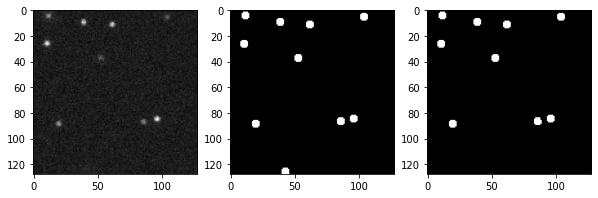

1/1 [==============================] - 0s 12ms/step


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.16021299482758 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


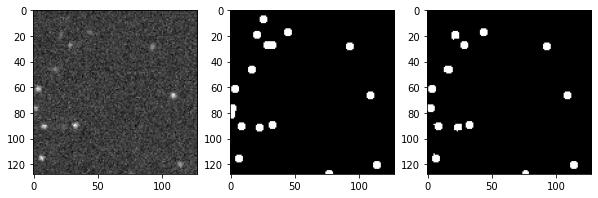

1/1 [==============================] - 0s 14ms/step


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 15.020121640482753 should be at most 0.5
To fix, set magnification to 31.0, and downsample the resulting image with dt.AveragePooling((31.0, 31.0, 1))

  warnings.warn(


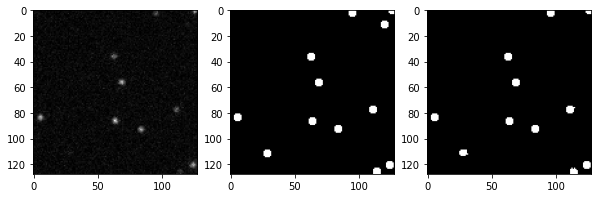

1/1 [==============================] - 0s 14ms/step


c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 14.399039625281212 should be at most 0.5
To fix, set magnification to 29.0, and downsample the resulting image with dt.AveragePooling((29.0, 29.0, 1))

  warnings.warn(


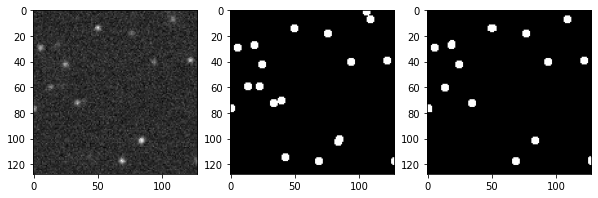

In [11]:
NUMBER_OF_IMAGES = 4


for _ in range(NUMBER_OF_IMAGES):
    plt.figure(figsize=(10, 10))
    dataset.update()
    image_of_particle = dataset.resolve(skip_augmentations=True)
    
    predicted_mask = model.predict(np.array([image_of_particle]))
    particle_label = get_label(image_of_particle)
    plt.subplot(1, 3, 1)
    plt.imshow(image_of_particle[..., 0], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.imshow(particle_label[..., 0] * 1.0, cmap="gray")
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask[0, ..., 0] > 0.5, cmap="gray")
    plt.show()

### 5.2 Prediction vs actual

We play a video of quantum dots, as tracked by the trained network.

In [12]:
import skimage.io

IMAGES_TO_PLAY=64

images = skimage.io.imread("./datasets/QuantumDots/Qdots.tif")
images = np.expand_dims(images[:IMAGES_TO_PLAY], axis=-1)
images = dt.NormalizeMinMax(0, 1).resolve(list(images))

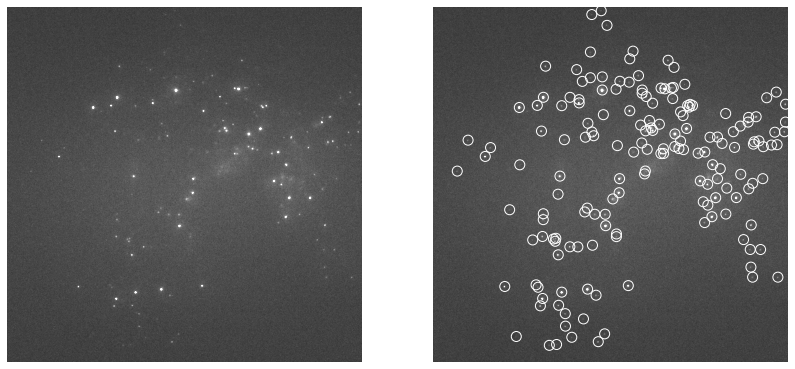

In [13]:
import IPython
to_predict_on = [images[i] / 3 + images[i + 1] / 3 + images[i-1] / 3 for i in range(1, len(images) - 1)]
predictions = model.predict(np.array(to_predict_on), batch_size=1)

for prediction, image in zip(predictions, images[1:-1]):
    plt.figure(figsize=(14, 7))
    mask = prediction[:,:,0] > 0.99
    
    cs = np.array(skimage.measure.regionprops(skimage.measure.label(mask)))
    
    cs = np.array([c["Centroid"] for c in cs])
    
    plt.subplot(1,2,1)
    plt.imshow(image[..., 0], vmax=0.1, cmap="gray")  
    plt.axis("off")
    plt.axis([0, 1200, 0, 1200])
    
    plt.subplot(1,2,2)
    plt.imshow(image[..., 0], vmax=0.1, cmap="gray")
    plt.scatter(cs[:, 1], cs[:, 0], 100, facecolors="none", edgecolors="w")
    plt.axis("off")
    plt.axis([0, 1200, 0, 1200])
    
    IPython.display.clear_output(wait=True)
    plt.show()
    plt.pause(0.1)
